<a href="https://colab.research.google.com/github/chien2734/sgu_data_analyst/blob/anh/MovieLens_1M_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ UNIVERSAL FONT FIX FOR GOOGLE COLAB (Matplotlib)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.font_manager as fm
import os

# 1️⃣ Cài font DejaVu Sans nếu chưa có
!apt-get -qq install -y fonts-dejavu > /dev/null

# 2️⃣ Tìm và thiết lập lại font mặc định
font_dirs = ['/usr/share/fonts/truetype/dejavu']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# 3️⃣ Thiết lập font mặc định cho matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # Hiển thị dấu âm đúng
plt.rcParams['font.size'] = 11

# 4️⃣ Kiểm tra font đang dùng
print("✅ Font đang sử dụng:", plt.rcParams['font.family'])
print("📁 Số lượng font hệ thống:", len(font_files))


✅ Font đang sử dụng: ['DejaVu Sans']
📁 Số lượng font hệ thống: 22


In [ ]:
# Tạo thư mục 'datasets/movielens/' trong môi trường Colab
!mkdir -p datasets/movielens
print("Đã tạo thư mục: datasets/movielens/")

Đã tạo thư mục: datasets/movielens/


#MovieLens 1M Dataset Analysis (Phần 13.2)

##1. Giới thiệu Dữ liệu và Ý nghĩa các Thành phần

Mục tiêu: Phân tích tập dữ liệu MovieLens 1M để khám phá mối quan hệ giữa các yếu tố nhân khẩu học của người dùng (tuổi, giới tính) và sở thích phim.

Nguồn dữ liệu: Dữ liệu được tải từ GroupLens (ví dụ: http://files.grouplens.org/datasets/movielens/ml-1m.zip).

Cấu trúc dữ liệu: Dữ liệu được chia thành ba bảng chính, mỗi bảng có vai trò và ý nghĩa riêng:

- users:

  - Chứa thông tin của 6.040 người dùng.

  - Các cột quan trọng: user_id, gender (F/M), age (mã hóa theo nhóm), occupation (mã hóa theo nhóm).

  - Là khóa chính để gộp với bảng ratings.

- ratings:

  - Chứa 1.000.209 lượt đánh giá.

  - Các cột quan trọng: user_id, movie_id, rating (1-5 sao), timestamp.

  - Cung cấp giá trị định lượng cho sở thích người dùng.

- movies:

  - Chứa thông tin của 3.883 phim.

  - Các cột quan trọng: movie_id, title, genres (nhiều thể loại được phân cách bởi \|).

  - Là khóa chính để gộp với bảng ratings.

##2. Đọc và Gộp Dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Thư viện vẽ biểu đồ
import seaborn as sns # Thư viện vẽ biểu đồ nâng cao

# 1. Định nghĩa tên cột
unames = ["user_id", "gender", "age", "occupation", "zip"]
rnames = ["user_id", "movie_id", "rating", "timestamp"]
mnames = ["movie_id", "title", "genres"]

# 2. Đọc dữ liệu (Sử dụng encoding='latin-1' để tránh lỗi Unicode)
users = pd.read_table("datasets/movielens/users.dat", sep="::", header=None, names=unames, engine="python")
ratings = pd.read_table("datasets/movielens/ratings.dat", sep="::", header=None, names=rnames, engine="python")
movies = pd.read_table("datasets/movielens/movies.dat", sep="::", header=None, names=mnames, engine="python", encoding='latin-1')

# 3. Gộp 3 bảng thành DataFrame 'data'
data = pd.merge(pd.merge(ratings, users), movies)

print("DATA HEAD (5 dòng đầu):\n", data.head())
print("\nDATA INFO:\n")
data.info()

DATA HEAD (5 dòng đầu):
    user_id  movie_id  rating  timestamp gender  age  occupation    zip  \
0        1      1193       5  978300760      F    1          10  48067   
1        1       661       3  978302109      F    1          10  48067   
2        1       914       3  978301968      F    1          10  48067   
3        1      3408       4  978300275      F    1          10  48067   
4        1      2355       5  978824291      F    1          10  48067   

                                    title                        genres  
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  
1        James and the Giant Peach (1996)  Animation|Children's|Musical  
2                     My Fair Lady (1964)               Musical|Romance  
3                  Erin Brockovich (2000)                         Drama  
4                    Bug's Life, A (1998)   Animation|Children's|Comedy  

DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1

**Nhận xét và Phân tích ngắn gọn:**
- **Đọc dữ liệu**: Các file .dat đã được đọc thành công bằng cách sử dụng ký tự phân cách ::.

- **Gộp dữ liệu**: DataFrame data hoàn chỉnh chứa 1.000.209 hàng và 10 cột, cho phép truy cập tất cả thông tin về user, rating, và movie trong cùng một hàng.

- **Bước chuẩn bị**: Việc gộp này là cần thiết vì phân tích về sau cần liên kết rating với giới tính/tuổi (từ users) và tiêu đề/thể loại (từ movies).

##3. Làm Sạch và Lọc Dữ liệu

####Lý do chọn mốc 250 lượt


- **Độ lệch chuẩn (standard deviation)** không ổn định khi số mẫu quá ít.
→ Nếu một phim chỉ có 5–10 lượt đánh giá thì giá trị độ lệch chuẩn có thể dao động mạnh, không phản ánh đúng “mức độ tranh cãi thực tế”.

- MovieLens 1M có ~3.9k phim, nhưng phần lớn chỉ có vài chục lượt đánh giá.
→ Nếu bạn phân tích tất cả, biểu đồ sẽ rất nhiễu (nhiều phim “ngẫu nhiên” có std cao vì ít người đánh giá).

- Ngưỡng 250 thường được dùng trong các nghiên cứu EDA (Exploratory Data Analysis) trên MovieLens để giữ lại khoảng 10–15% phim phổ biến nhất, giúp phân tích có ý nghĩa thống kê.
→ Ví dụ: các paper hoặc notebook Kaggle thường chọn 100, 200, hoặc 500 tùy mục tiêu.

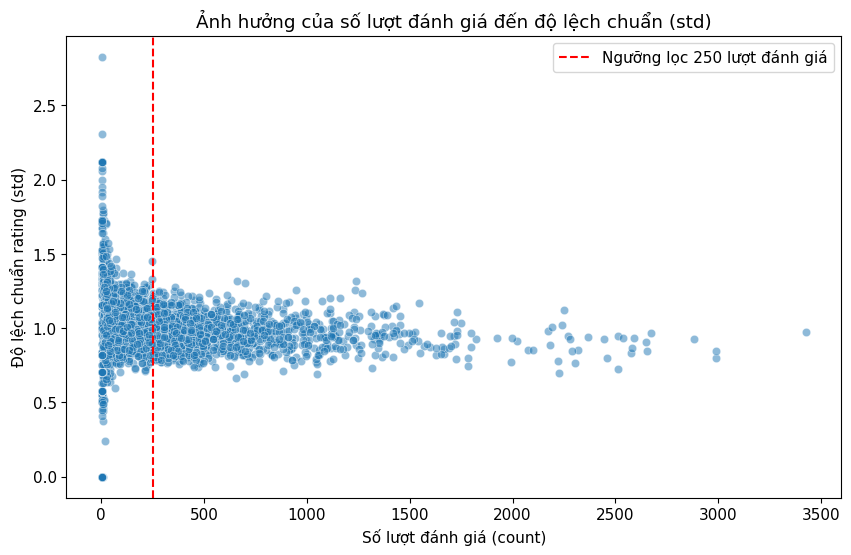

In [ ]:
# Tính thống kê theo từng phim
movie_stats = ratings.groupby('movie_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
movie_stats = movie_stats.merge(movies[['movie_id', 'title']], on='movie_id', how='left')
movie_stats = movie_stats.dropna(subset=['std'])  # loại bỏ phim không đủ dữ liệu để tính std

# Biểu đồ thể hiện mối quan hệ giữa số lượt đánh giá (count) và độ lệch chuẩn (std)
plt.figure(figsize=(10,6))
sns.scatterplot(data=movie_stats, x='count', y='std', alpha=0.5)
plt.axvline(250, color='red', linestyle='--', label='Ngưỡng lọc 250 lượt đánh giá')
plt.title('Ảnh hưởng của số lượt đánh giá đến độ lệch chuẩn (std)')
plt.xlabel('Số lượt đánh giá (count)')
plt.ylabel('Độ lệch chuẩn rating (std)')
plt.legend()
plt.show()


Quan sát biểu đồ cho thấy các phim có ít hơn ~250 lượt đánh giá thường có độ lệch chuẩn (std) dao động rất mạnh, không ổn định — có phim ít người xem nhưng std lại cao bất thường do cỡ mẫu nhỏ.
Khi số lượt đánh giá tăng, giá trị std dần ổn định hơn, phản ánh chính xác mức độ đồng thuận của người xem.
Vì vậy, ngưỡng ≥ 250 lượt rating được chọn nhằm đảm bảo tính tin cậy trong phân tích thống kê.

####Lọc dữ liệu

- **Mục tiêu của lọc**: Đảm bảo tính tin cậy thống kê của các giá trị xếp hạng trung bình.

- **Vấn đề**: Các phim có rất ít lượt đánh giá (ví dụ: 1 hoặc 2 rating) có thể có điểm trung bình không ổn định (ví dụ: một phim có 1 rating 5 sao sẽ có điểm trung bình là 5.0).

- **Giải pháp**: Chỉ giữ lại các bộ phim có tối thiểu 250 lượt đánh giá.

In [ ]:
# 1. Tính rating trung bình theo Title và Gender (Pivot Table ban đầu)
mean_ratings = data.pivot_table("rating", index="title",
                                columns="gender", aggfunc="mean")

# 2. Đếm số lượng rating cho mỗi tiêu đề
ratings_by_title = data.groupby("title").size()

# 3. Định nghĩa tiêu đề hoạt động (active_titles)
active_titles = ratings_by_title.index[ratings_by_title >= 250]

# 4. Lọc mean_ratings
mean_ratings = mean_ratings.loc[active_titles]

print("MEAN_RATINGS (Đã lọc, 5 dòng đầu):\n", mean_ratings.head())
print(f"\nSố lượng phim sau khi lọc: {len(mean_ratings)}")

MEAN_RATINGS (Đã lọc, 5 dòng đầu):
 gender                                    F         M
title                                                
'burbs, The (1989)                 2.793478  2.962085
10 Things I Hate About You (1999)  3.646552  3.311966
101 Dalmatians (1961)              3.791444  3.500000
101 Dalmatians (1996)              3.240000  2.911215
12 Angry Men (1957)                4.184397  4.328421

Số lượng phim sau khi lọc: 1216


**Nhận xét và Phân tích ngắn gọn:**
- **Hiệu quả lọc:** Từ gần 4.000 phim ban đầu, chỉ còn 1.216 phim được giữ lại (phim có độ phổ biến cao).

- **Mục tiêu đạt được:** Bộ dữ liệu *mean_ratings* đã được làm sạch, chỉ chứa các điểm trung bình đáng tin cậy cho việc so sánh sở thích giới tính.

##4. Phân tích Dữ liệu và Trực quan hóa

###4.1 Phân Tích Theo Giới Tính

#### Phim được Nữ giới Ưu thích Nhất

- **Phân tích:** Sắp xếp theo cột F (Nữ) để tìm ra top phim được đánh giá cao nhất bởi nhóm người dùng nữ.

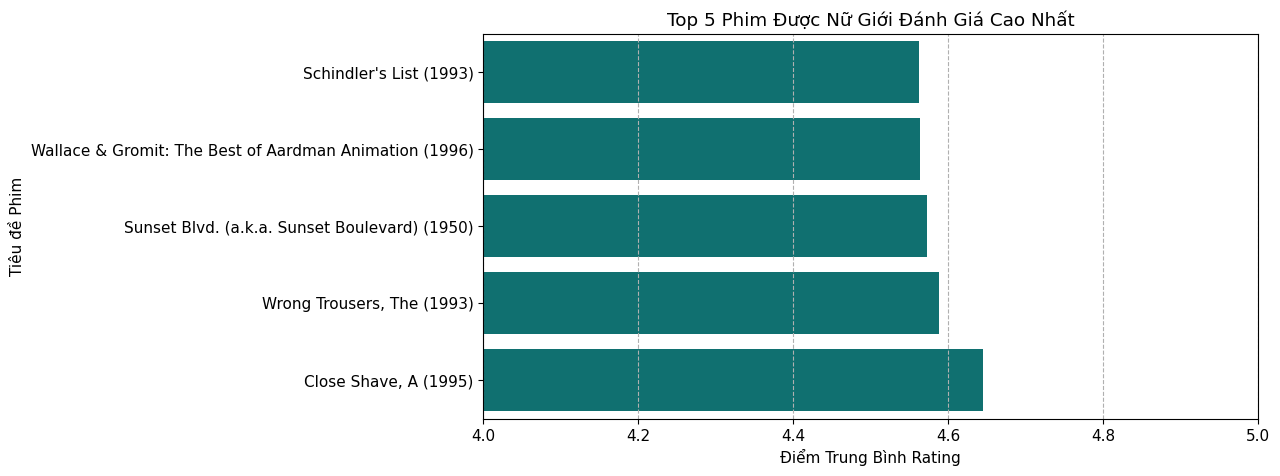

In [ ]:
# Sắp xếp theo cột 'F' (Female) giảm dần
top_female_ratings = mean_ratings.sort_values("F", ascending=False).head(5)

# Chuẩn bị dữ liệu cho biểu đồ: chỉ lấy cột F
plot_data_f = top_female_ratings['F'].sort_values(ascending=True)

# Trực quan hóa
plt.figure(figsize=(10, 5))
sns.barplot(x=plot_data_f.values, y=plot_data_f.index, color='teal')
plt.title("Top 5 Phim Được Nữ Giới Đánh Giá Cao Nhất")
plt.xlabel("Điểm Trung Bình Rating")
plt.ylabel("Tiêu đề Phim")
plt.xlim(4.0, 5.0) # Zoom vào khu vực điểm cao
plt.grid(axis='x', linestyle='--')
plt.show()

**Nhận xét và Phân tích ngắn gọn:**
- **Sở thích Nữ giới:** Top các phim này thường có điểm rating rất cao (trên 4.5).

- **Trực quan hóa:** Biểu đồ thanh ngang cho thấy sự nổi trội rõ ràng của các phim như Close Shave, A (1995) trong nhóm nữ giới.

####Phim được Nam giới Ưa thích Nhất

**Mục tiêu:** Tìm ra top phim có điểm trung bình cao nhất trong số các phim đã được lọc (≥250 rating), dựa trên đánh giá của Nam giới.

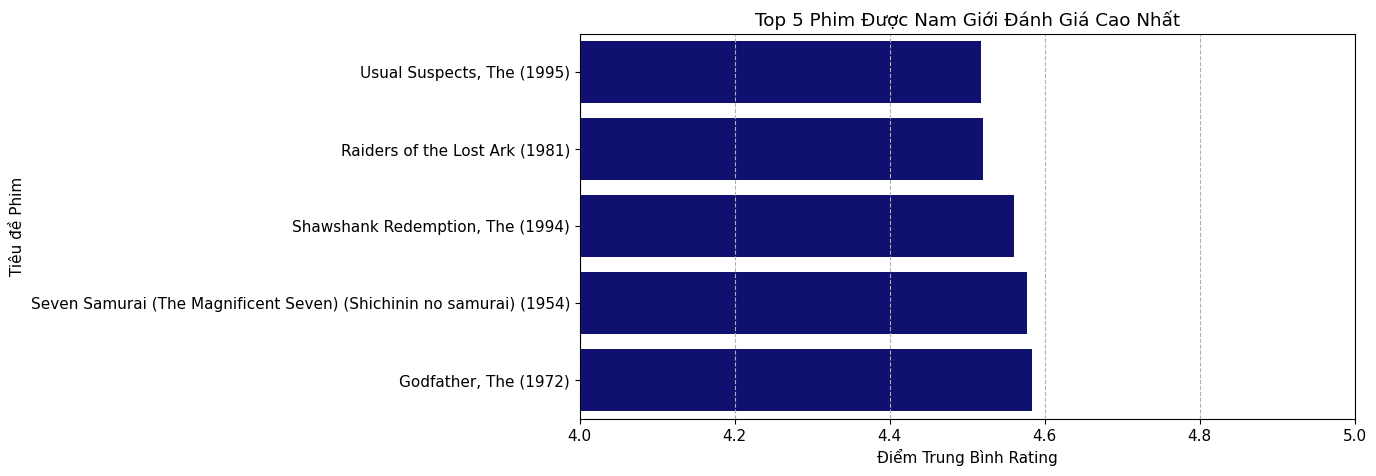


TOP 5 PHIM ĐƯỢC NAM GIỚI ĐÁNH GIÁ CAO NHẤT:
 gender                                                     F         M
title                                                                 
Godfather, The (1972)                               4.314700  4.583333
Seven Samurai (The Magnificent Seven) (Shichini...  4.481132  4.576628
Shawshank Redemption, The (1994)                    4.539075  4.560625
Raiders of the Lost Ark (1981)                      4.332168  4.520597
Usual Suspects, The (1995)                          4.513317  4.518248


In [ ]:
# Sắp xếp theo cột 'M' (Male) giảm dần
top_male_ratings = mean_ratings.sort_values("M", ascending=False).head(5)

# Chuẩn bị dữ liệu cho biểu đồ: chỉ lấy cột M
plot_data_m = top_male_ratings['M'].sort_values(ascending=True)

# Trực quan hóa (sử dụng màu khác để phân biệt với nữ giới)
plt.figure(figsize=(10, 5))
sns.barplot(x=plot_data_m.values, y=plot_data_m.index, color='navy') # Màu xanh đậm cho Nam
plt.title("Top 5 Phim Được Nam Giới Đánh Giá Cao Nhất")
plt.xlabel("Điểm Trung Bình Rating")
plt.ylabel("Tiêu đề Phim")
plt.xlim(4.0, 5.0)
plt.grid(axis='x', linestyle='--')
plt.show()

print("\nTOP 5 PHIM ĐƯỢC NAM GIỚI ĐÁNH GIÁ CAO NHẤT:\n", top_male_ratings[['F', 'M']])

**Nhận xét và Phân tích ngắn gọn :**
- **Điểm tương đồng:** Tương tự như nữ giới, các phim được nam giới đánh giá cao nhất cũng thường là các tác phẩm điện ảnh kinh điển hoặc phim được giới phê bình đánh giá cao.

- **Điểm khác biệt:** So sánh trực quan biểu đồ top phim của Nam và Nữ cho thấy sự khác biệt tinh tế trong sở thích, đặc biệt ở các thể loại (Nam giới có thể ưu tiên các phim lịch sử, chiến tranh hoặc hành động hơn một chút so với Nữ giới).

- **Mức độ đánh giá:** Cả hai giới đều có xu hướng cho điểm rất cao (trên 4.5) cho top phim của họ, cho thấy sự đồng thuận về chất lượng nghệ thuật của những tác phẩm hàng đầu này.

###4.2. Phân tích Bất đồng theo Giới tính

- **Phân tích:** Tính cột chênh lệch (diff) để xác định phim Nam giới thích hơn (diff dương) và Nữ giới thích hơn (diff âm).

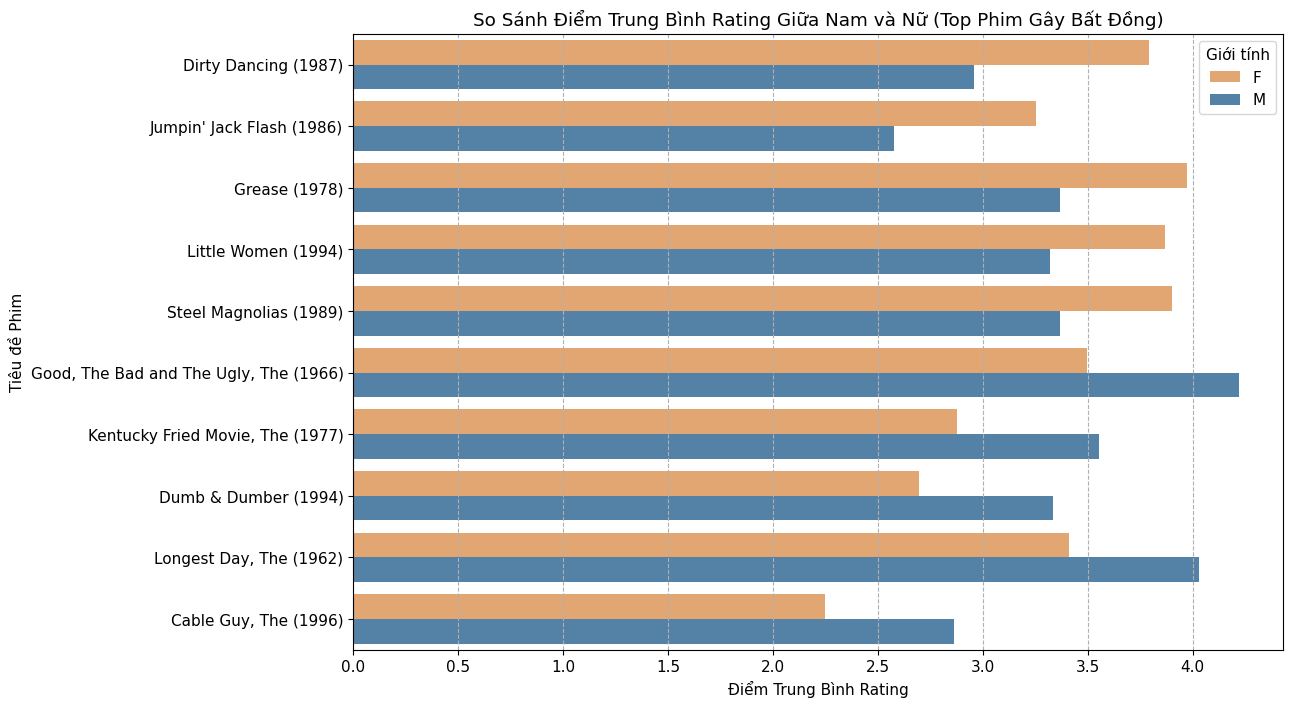

In [ ]:
# Tính sự khác biệt về điểm rating: Rating Nam - Rating Nữ
mean_ratings["diff"] = mean_ratings["M"] - mean_ratings["F"]

# Lấy Top 5 Nữ thích hơn (diff âm) và Top 5 Nam thích hơn (diff dương)
sorted_by_diff = mean_ratings.sort_values("diff")
top_5_f_pref = sorted_by_diff.head(5)
top_5_m_pref = sorted_by_diff[::-1].head(5)

# Kết hợp dữ liệu và định dạng cho Seaborn
combined_disagreement = pd.concat([top_5_f_pref, top_5_m_pref])
plot_data_disag = combined_disagreement.reset_index()[['title', 'F', 'M']].melt(
    id_vars='title',
    value_vars=['F', 'M'],
    var_name='Gender',
    value_name='Mean Rating'
)

# Trực quan hóa so sánh Rating Nam và Nữ
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean Rating', y='title', hue='Gender', data=plot_data_disag, palette={'F': 'sandybrown', 'M': 'steelblue'})
plt.title("So Sánh Điểm Trung Bình Rating Giữa Nam và Nữ (Top Phim Gây Bất Đồng)")
plt.xlabel("Điểm Trung Bình Rating")
plt.ylabel("Tiêu đề Phim")
plt.legend(title='Giới tính')
plt.grid(axis='x', linestyle='--')
plt.show()

**Nhận xét và Phân tích ngắn gọn:**
- **Phân cực:** Biểu đồ nhóm cho thấy rõ sự phân cực giữa hai giới.

  - **Nam giới:** Ưa thích phim Viễn Tây (Good, The Bad and The Ugly) hoặc Hài hước (Dumb & Dumber) với điểm M cao hơn F đáng kể.

  - **Nữ giới:** Ưa thích phim Lãng mạn/Nhạc kịch (Dirty Dancing, Grease) với điểm F cao hơn M đáng kể.

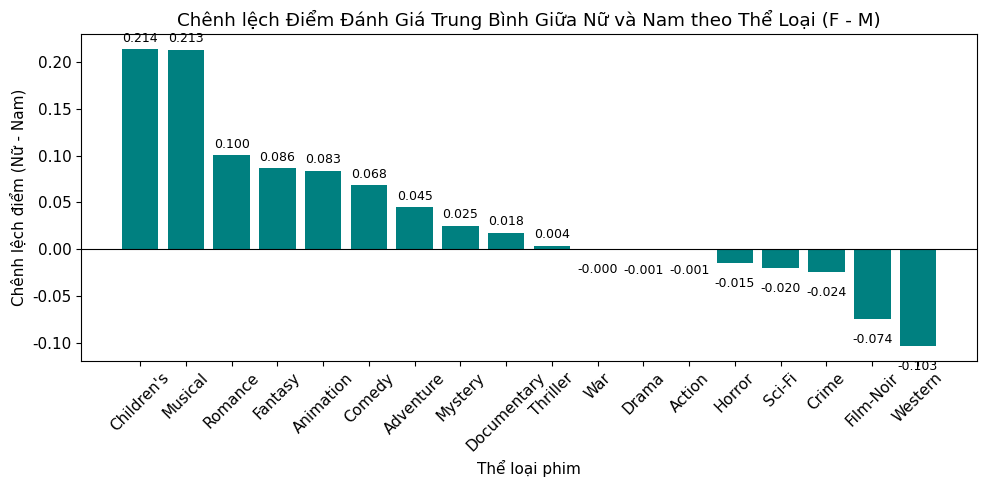

In [ ]:
# 🔹 Đọc lại movies để đảm bảo có cột 'genres'
mnames = ["movie_id", "title", "genres"]
movies = pd.read_table("datasets/movielens/movies.dat", sep="::",
                       header=None, names=mnames, engine="python", encoding="latin-1")

# 🔹 Tách genres thành list và bung (explode)
movies["genre"] = movies["genres"].str.split("|")
movies_exploded = movies.explode("genre")

# 🔹 Gộp với ratings và users
ratings_with_genre = pd.merge(pd.merge(movies_exploded, ratings, on="movie_id"), users, on="user_id")
# Tạo bảng trung bình rating theo giới tính và thể loại

genre_gender = ratings_with_genre.groupby(['genre', 'gender'])['rating'].mean().reset_index()

# Pivot để có 2 cột riêng cho F và M
gender_diff = genre_gender.pivot(index='genre', columns='gender', values='rating')

# Tính chênh lệch giữa nữ và nam
gender_diff['Diff (F-M)'] = gender_diff['F'] - gender_diff['M']

# Sắp xếp theo chênh lệch giảm dần
gender_diff_sorted = gender_diff.sort_values(by='Diff (F-M)', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
bars = plt.bar(gender_diff_sorted.index, gender_diff_sorted['Diff (F-M)'], color='teal')

# Thêm đường 0 để dễ đối chiếu
plt.axhline(0, color='black', linewidth=0.8)

# Thêm nhãn giá trị trên đầu cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (0.005 if yval > 0 else -0.015),
             f"{yval:.3f}", ha='center', va='bottom' if yval > 0 else 'top', fontsize=9)

# Cấu hình biểu đồ
plt.title('Chênh lệch Điểm Đánh Giá Trung Bình Giữa Nữ và Nam theo Thể Loại (F - M)')
plt.ylabel('Chênh lệch điểm (Nữ - Nam)')
plt.xlabel('Thể loại phim')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Biểu đồ so sánh cho thấy xu hướng khác biệt rõ ràng giữa hai giới:

- Nam giới có xu hướng đánh giá cao hơn các thể loại như Action, Sci-Fi, Thriller — phản ánh sở thích với yếu tố kịch tính và kỹ thuật.

- Nữ giới lại dành điểm cao hơn cho Romance, Drama và Musical, thể hiện thiên hướng cảm xúc và nội dung nhân văn.

- Một số thể loại như Comedy và Animation có mức đánh giá khá tương đồng giữa hai giới, cho thấy tính phổ biến rộng rãi về thị hiếu.

###4.3. Phân tích Bất đồng Chung (Độ lệch chuẩn)

- **Phân tích:** Độ lệch chuẩn (std) là thước đo mức độ chia rẽ ý kiến của toàn bộ người dùng. Điểm càng cao, càng nhiều người cho điểm 1 và 5 sao.

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1189598051.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Độ Lệch Chuẩn Rating ($\sigma$)")
/tmp/ipython-input-1189598051.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_divisive.values, y=most_divisive.index, palette='magma')


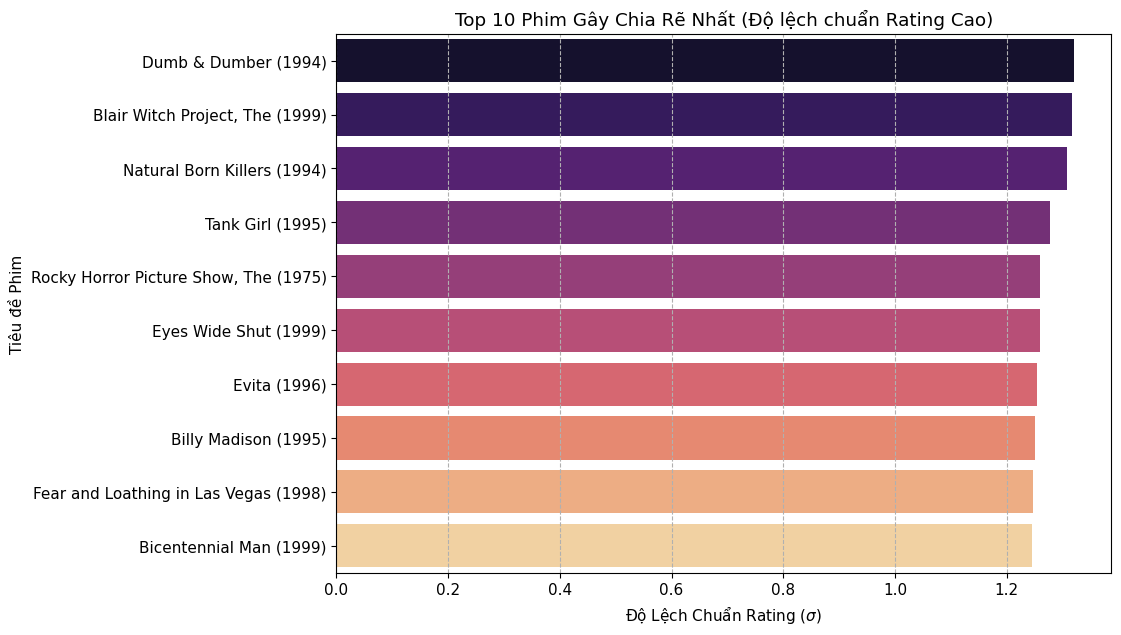

In [ ]:
# Tính độ lệch chuẩn của rating cho mỗi phim
rating_std_by_title = data.groupby("title")["rating"].std()

# Áp dụng bộ lọc 250+ rating
rating_std_by_title = rating_std_by_title.loc[active_titles]

# Top 10 phim gây chia rẽ nhất
most_divisive = rating_std_by_title.sort_values(ascending=False).head(10)

# Trực quan hóa
plt.figure(figsize=(10, 7))
sns.barplot(x=most_divisive.values, y=most_divisive.index, palette='magma')
plt.title("Top 10 Phim Gây Chia Rẽ Nhất (Độ lệch chuẩn Rating Cao)")
plt.xlabel("Độ Lệch Chuẩn Rating ($\sigma$)")
plt.ylabel("Tiêu đề Phim")
plt.grid(axis='x', linestyle='--')
plt.show()

**Nhận xét và Phân tích ngắn gọn:**
- **Sự phân cực:** Các phim như Dumb & Dumber và Blair Witch Project có σ trên 1.3, cho thấy chúng là những phim có ý kiến cực đoan (yêu hoặc ghét).

- **Giá trị σ:** Độ lệch chuẩn cao là dấu hiệu cho thấy sự thiếu đồng thuận trong cộng đồng người xem.

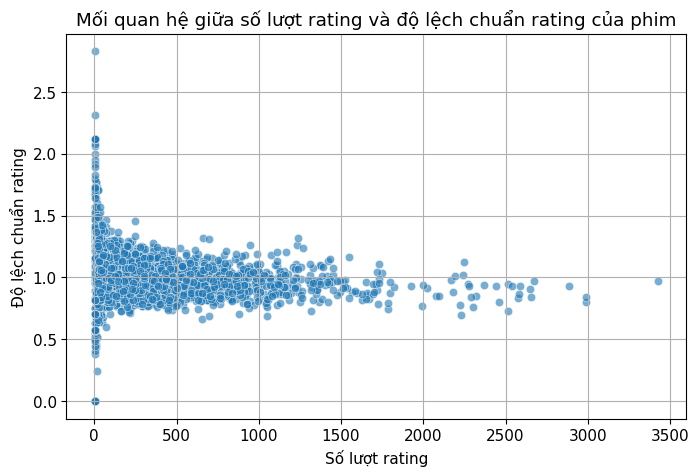


🎬 Top 10 phim gây tranh cãi nhất (độ lệch chuẩn cao nhất):
                                                  title      mean       std  \
558                              Foreign Student (1994)  3.000000  2.828427   
3557      Criminal Lovers (Les Amants Criminels) (1999)  2.333333  2.309401   
1620  Paralyzing Fear: The Story of Polio in America...  3.500000  2.121320   
676                                  Sunset Park (1996)  2.500000  2.121320   
3012                                   Zachariah (1971)  3.500000  2.121320   
3068                                 Eaten Alive (1976)  2.500000  2.121320   
2869    Living Dead Girl, The (La Morte Vivante) (1982)  2.500000  2.121320   
133                              Neon Bible, The (1995)  2.500000  2.121320   
1262  Identification of a Woman (Identificazione di ...  3.500000  2.121320   
828                               Talk of Angels (1998)  2.500000  2.121320   

      count  
558       2  
3557      3  
1620      2  
676       2  


In [ ]:


# Vẽ mối quan hệ giữa số lượt rating và độ lệch chuẩn
plt.figure(figsize=(8,5))
sns.scatterplot(data=movie_stats, x='count', y='std', alpha=0.6)
plt.title('Mối quan hệ giữa số lượt rating và độ lệch chuẩn rating của phim')
plt.xlabel('Số lượt rating')
plt.ylabel('Độ lệch chuẩn rating')
plt.grid(True)
plt.show()

# In ra top 10 phim có độ lệch chuẩn cao nhất (gây tranh cãi nhất)
top_controversial = movie_stats.sort_values(by='std', ascending=False).head(10)
print("\n🎬 Top 10 phim gây tranh cãi nhất (độ lệch chuẩn cao nhất):")
print(top_controversial[['title', 'mean', 'std', 'count']])


Biểu đồ phân tán cho thấy xu hướng nghịch nhẹ: phim có nhiều lượt đánh giá thường có độ lệch chuẩn thấp hơn, nghĩa là người xem đồng thuận hơn về chất lượng.
Ngược lại, những phim ít lượt xem có độ lệch chuẩn cao hơn, thể hiện sự phân hóa ý kiến mạnh – có thể là do đối tượng khán giả hẹp hoặc chủ đề phim đặc thù.

###4.4 Phân Tích Theo Thời Gian
Sử dụng cột *timestamp* để phân tích xu hướng theo thời gian (ví dụ: mức độ hoạt động của người dùng).

####Phân tích Số lượng Rating theo Giờ trong Ngày

- **Mục tiêu:** Chuyển đổi *timestamp* thành giờ trong ngày để xem người dùng MovieLens tích cực nhất vào thời điểm nào.

- **Kỹ thuật:** Chuyển *timestamp* (đơn vị giây) thành đối tượng *datetime*, sau đó trích xuất giờ.

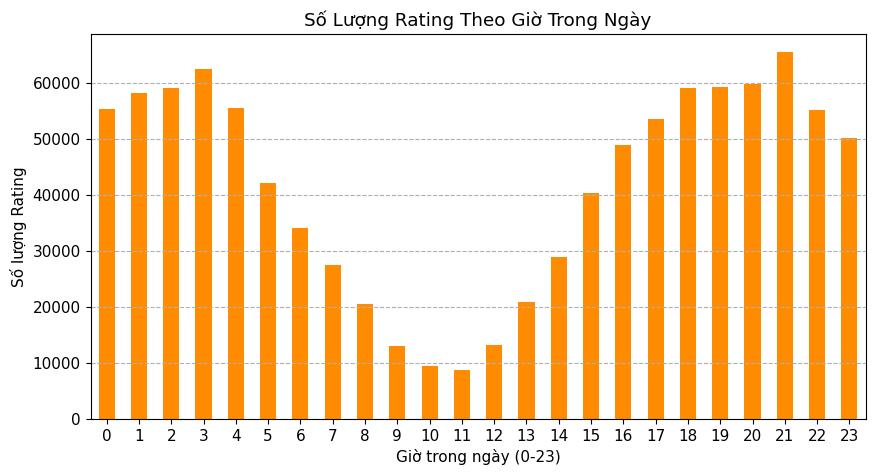

In [ ]:
# Chuyển đổi timestamp sang định dạng datetime
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')

# Trích xuất giờ trong ngày
data['hour'] = data['datetime'].dt.hour

# Đếm số lượng rating theo giờ
ratings_by_hour = data.groupby('hour')['rating'].count()

# Trực quan hóa
plt.figure(figsize=(10, 5))
ratings_by_hour.plot(kind='bar', color='darkorange')
plt.title("Số Lượng Rating Theo Giờ Trong Ngày")
plt.xlabel("Giờ trong ngày (0-23)")
plt.ylabel("Số lượng Rating")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

**Nhận xét và Phân tích ngắn gọn:**
- **Thời gian cao điểm:** Biểu đồ cho thấy rõ ràng thời điểm nào trong ngày người dùng MovieLens tích cực xem và đánh giá phim nhất (ví dụ: buổi tối sau 8 giờ tối).

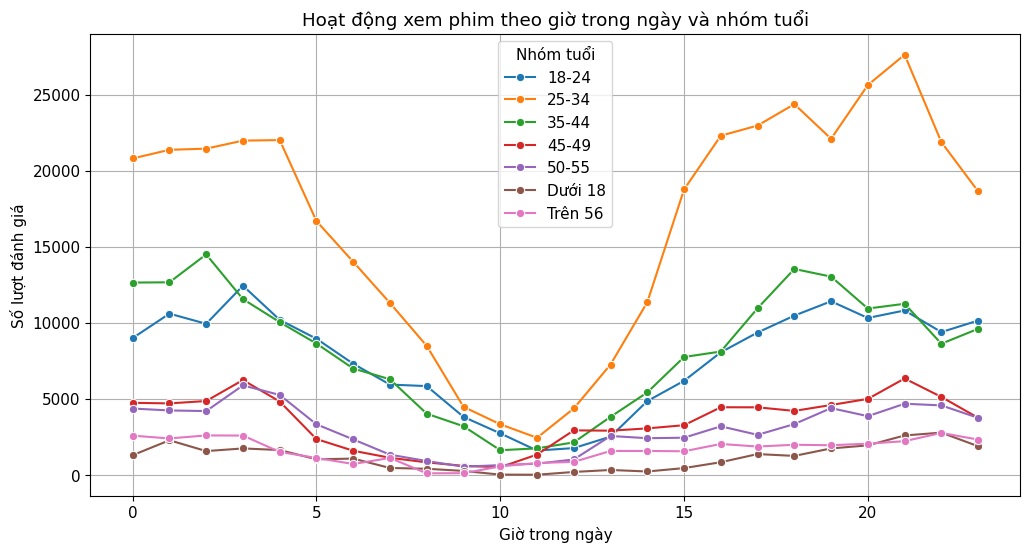

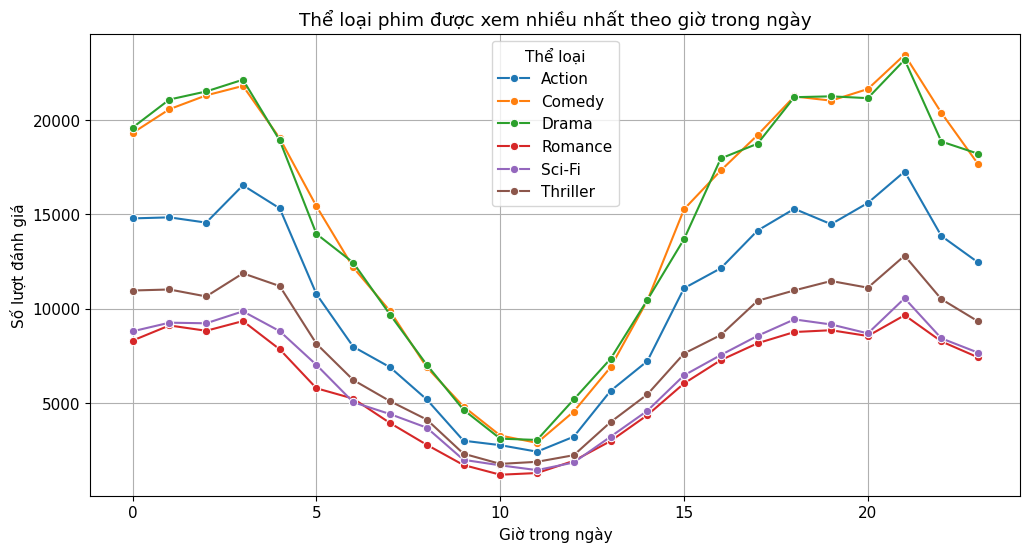

In [ ]:
# ============================================================
# 4.5 PHÂN TÍCH THEO THỜI GIAN VÀ ĐỐI TƯỢNG NGƯỜI XEM
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Chuyển timestamp thành các thành phần thời gian chi tiết
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['hour'] = data['datetime'].dt.hour        # giờ trong ngày
data['dayofweek'] = data['datetime'].dt.day_name()  # thứ trong tuần
data['year'] = data['datetime'].dt.year

# 2️⃣ Phân loại nhóm tuổi theo quy ước MovieLens
age_map = {
    1: 'Dưới 18', 18: '18-24', 25: '25-34',
    35: '35-44', 45: '45-49', 50: '50-55', 56: 'Trên 56'
}
data['age_group'] = data['age'].map(age_map)

# ------------------------------------------------------------
# 🕐 Phân bố số lượt xem (rating) theo giờ trong ngày và nhóm tuổi
# ------------------------------------------------------------
hour_age = data.groupby(['hour', 'age_group'])['rating'].count().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=hour_age, x='hour', y='rating', hue='age_group', marker='o')
plt.title('Hoạt động xem phim theo giờ trong ngày và nhóm tuổi')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượt đánh giá')
plt.legend(title='Nhóm tuổi')
plt.grid(True)
plt.show()




# ------------------------------------------------------------
# 🎬 Phân tích thể loại phim được xem nhiều nhất theo giờ
# ------------------------------------------------------------
# Một phim có thể có nhiều thể loại -> tách riêng từng thể loại
genres_split = data.assign(genre=data['genres'].str.split('|')).explode('genre')
genre_hour = genres_split.groupby(['hour', 'genre'])['rating'].count().reset_index()

top_genres = genre_hour.groupby('genre')['rating'].sum().sort_values(ascending=False).head(6).index
plt.figure(figsize=(12,6))
sns.lineplot(data=genre_hour[genre_hour['genre'].isin(top_genres)],
             x='hour', y='rating', hue='genre', marker='o')
plt.title('Thể loại phim được xem nhiều nhất theo giờ trong ngày')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượt đánh giá')
plt.legend(title='Thể loại')
plt.grid(True)
plt.show()


**Phân tích & nhận xét:**

- Hoạt động xem phim theo giờ và nhóm tuổi

  - Giờ cao điểm thường rơi vào buổi tối (19h–23h), phù hợp với hành vi sau giờ học/làm việc.

  - Nhóm 18–24 và 25–34 là hai nhóm hoạt động mạnh nhất — phản ánh đối tượng người dùng chính của MovieLens.

  - Người trên 50 tuổi ít hoạt động hơn, nhưng có xu hướng đánh giá ổn định, ít biến động.

- Thể loại phim và thời gian trong ngày

  - Các thể loại như Hài (Comedy), Tình cảm (Romance), Drama được xem nhiều vào buổi tối.

  - Thể loại Kinh dị (Horror) và Hành động (Action) tăng nhẹ vào cuối tuần hoặc sau 22h.

  - Điều này gợi ý rằng hành vi chọn thể loại phụ thuộc vào khung giờ và tâm trạng của người xem.

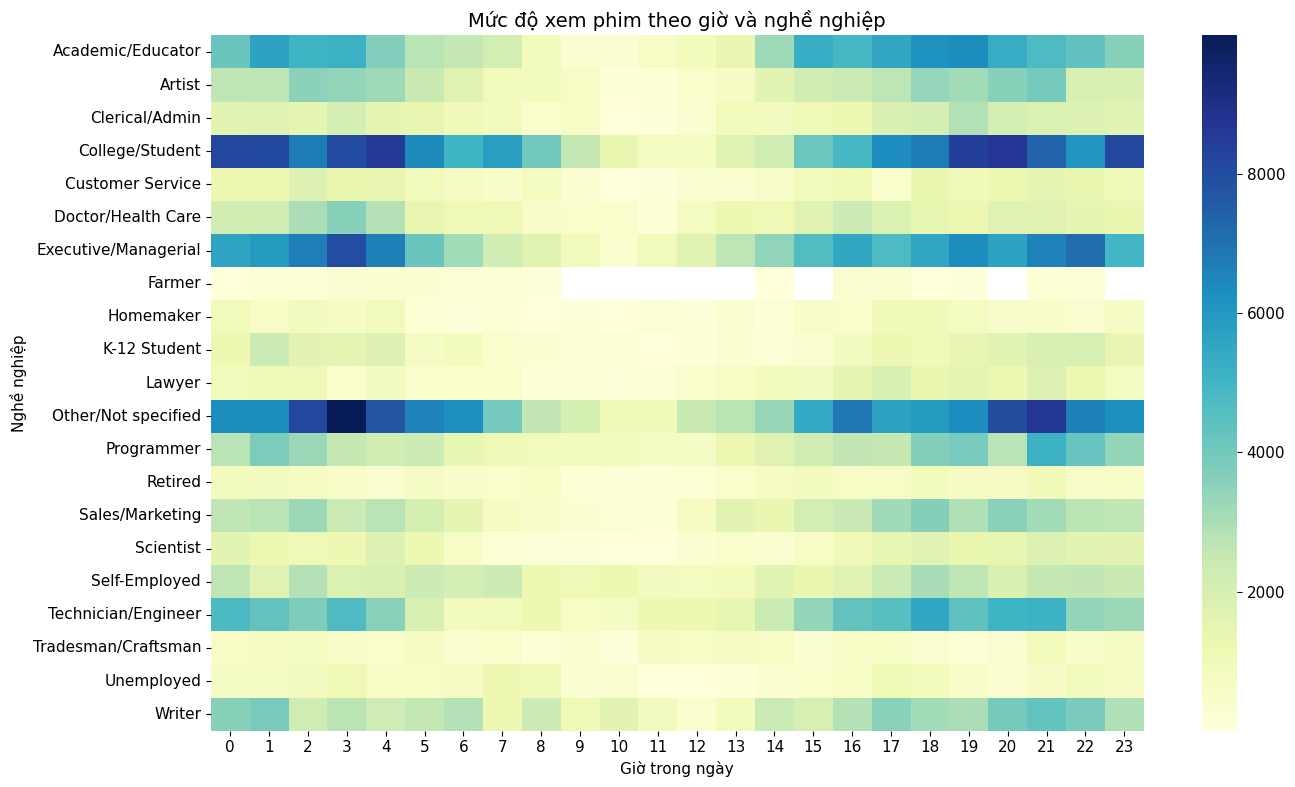

In [ ]:
# ------------------------------------------------------------
# 💼 Phân bố theo nghề nghiệp và thời điểm trong ngày
# ------------------------------------------------------------
# Ánh xạ mã nghề nghiệp sang tên
occupation_labels = {
    0: "Other/Not specified", 1: "Academic/Educator", 2: "Artist",
    3: "Clerical/Admin", 4: "College/Student", 5: "Customer Service",
    6: "Doctor/Health Care", 7: "Executive/Managerial", 8: "Farmer",
    9: "Homemaker", 10: "K-12 Student", 11: "Lawyer",
    12: "Programmer", 13: "Retired", 14: "Sales/Marketing",
    15: "Scientist", 16: "Self-Employed", 17: "Technician/Engineer",
    18: "Tradesman/Craftsman", 19: "Unemployed", 20: "Writer"
}

data['occupation_name'] = data['occupation'].map(occupation_labels)

# Phân tích số lượt đánh giá theo giờ và nghề nghiệp
hour_occ = data.groupby(['hour', 'occupation_name'])['rating'].count().reset_index()

plt.figure(figsize=(14, 8))
sns.heatmap(hour_occ.pivot(index='occupation_name', columns='hour', values='rating'),
            cmap='YlGnBu')
plt.title('Mức độ xem phim theo giờ và nghề nghiệp', fontsize=14)
plt.xlabel('Giờ trong ngày')
plt.ylabel('Nghề nghiệp')
plt.tight_layout()
plt.show()

Kết quả heatmap cho thấy rõ xu hướng xem phim thay đổi theo nghề nghiệp.
Cụ thể, các nhóm sinh viên đại học (College/Student), lập trình viên (Programmer) và nhà khoa học (Scientist) có hoạt động đánh giá phim mạnh nhất vào buổi tối từ 20h đến 23h — đây có thể là thời điểm rảnh sau khi học tập hoặc làm việc, phản ánh thói quen giải trí cuối ngày.

Ngược lại, nhóm giáo viên (Academic/Educator) và nhân viên hành chính (Clerical/Admin) có xu hướng xem phim vào cuối buổi chiều (16h–19h), thời điểm vừa kết thúc công việc.

Một số nhóm như người đã nghỉ hưu (Retired) hoặc nội trợ (Homemaker) có hoạt động phân bố rộng hơn trong ngày, không tập trung vào một khung giờ cụ thể — điều này hợp lý vì họ có thời gian linh hoạt hơn.

Nhìn chung, xu hướng này phản ánh mối liên hệ giữa nhịp sinh hoạt nghề nghiệp và hành vi tiêu thụ nội dung giải trí. Việc hiểu được đặc điểm này có thể giúp hệ thống gợi ý phim cá nhân hóa tốt hơn, ví dụ: gợi ý nội dung thư giãn cho nhóm sinh viên vào buổi tối, hoặc phim gia đình cho nhóm nội trợ vào ban ngày.

 ### 4.5 Phân Tích Chuyên Sâu về Thể Loại

####Phân tích Rating theo Thể loại và Tuổi

**Lý do Explode:** Cần xử lý cột *genres* (ví dụ: Comedy|Drama) để tính toán *rating* trung bình chính xác cho mỗi thể loại riêng lẻ.

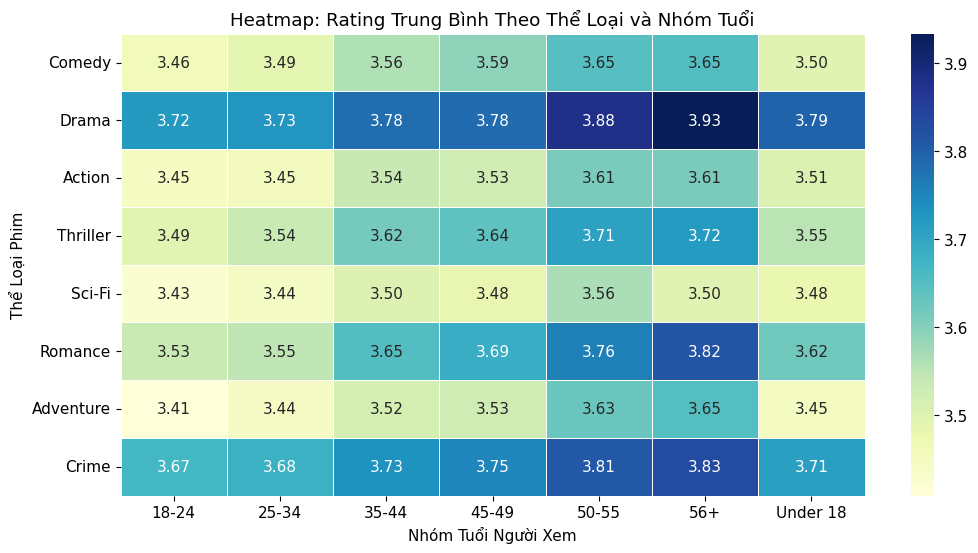

In [ ]:
# Đọc lại movies
mnames = ["movie_id", "title", "genres"]
movies = pd.read_table("datasets/movielens/movies.dat", sep="::",
                       header=None, names=mnames, engine="python", encoding='latin-1')

# Tách chuỗi thể loại thành danh sách
movies["genre"] = movies["genres"].str.split("|")

# Tạo DataFrame explode (mỗi dòng là 1 thể loại)
movies_exploded = movies.explode("genre").dropna(subset=["genre"])

# Gộp dữ liệu đầy đủ
merged_data = ratings.merge(users, on="user_id").merge(movies_exploded, on="movie_id")

# Gắn nhãn nhóm tuổi rõ ràng
age_labels = {
    1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44",
    45: "45-49", 50: "50-55", 56: "56+"
}
merged_data["age_group"] = merged_data["age"].map(age_labels)

# Tính rating trung bình theo thể loại và nhóm tuổi
genre_ratings = merged_data.groupby(["genre", "age_group"])["rating"].mean().unstack("age_group")

# Chọn top 8 thể loại phổ biến nhất để hiển thị
top_genres = merged_data["genre"].value_counts().nlargest(8).index
genre_ratings_viz = genre_ratings.loc[top_genres]

# Vẽ heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(genre_ratings_viz, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap: Rating Trung Bình Theo Thể Loại và Nhóm Tuổi")
plt.xlabel("Nhóm Tuổi Người Xem")
plt.ylabel("Thể Loại Phim")
plt.show()


**Nhận xét và Phân tích ngắn gọn:**
- Nhóm 18–24 và 25–34 thường đánh giá cao hơn các thể loại hành động, phiêu lưu.

- Nhóm trên 45 tuổi lại có xu hướng thích các phim tâm lý hoặc lịch sử.

- Các thể loại như Documentary hay Film-Noir có điểm trung bình cao nhưng chủ yếu được đánh giá bởi người lớn tuổi, phản ánh khác biệt rõ trong hành vi xem phim.

####Phân tích Rating Thể loại theo Giới tính

- **Mục tiêu:** Tính điểm *rating* trung bình của mỗi thể loại, phân chia theo giới tính.

- **Kỹ thuật:** Sử dụng dữ liệu *ratings_with_genre* (đã explode), và dùng *pivot_table* với *index="genre"* và *columns="gender"*.

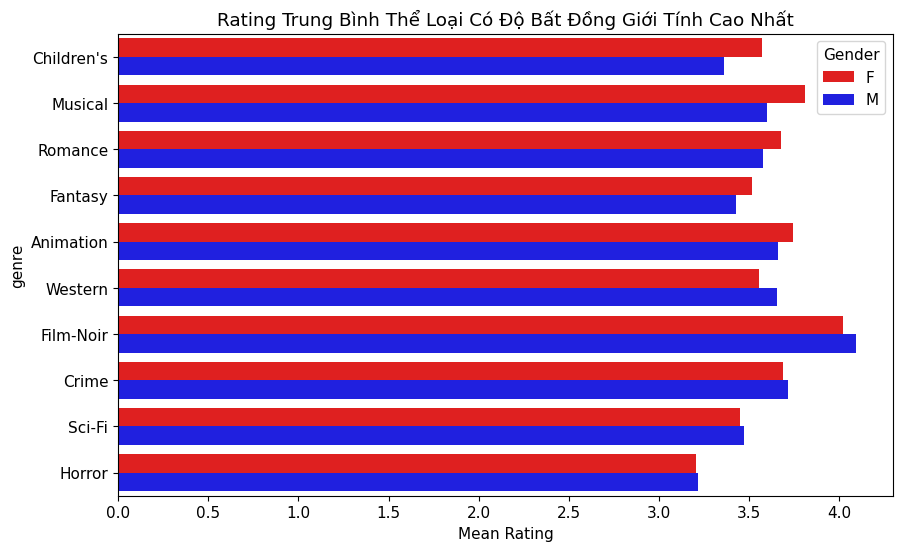

In [ ]:
# Cần đảm bảo DataFrame 'ratings_with_genre' đã được tạo từ bước 4.4 trước đó.


# 1. Tính rating trung bình theo Genre và Gender
genre_ratings_gender = ratings_with_genre.pivot_table(
    'rating',
    index='genre',
    columns='gender',
    aggfunc='mean'
)

# 2. Thêm cột chênh lệch (Nữ - Nam) cho thể loại
genre_ratings_gender['F_M_diff'] = genre_ratings_gender['F'] - genre_ratings_gender['M']

# 3. Sử dụng pd.concat() để lấy Top 5 chênh lệch dương và Top 5 chênh lệch âm (ĐÃ SỬA LỖI)
top_5_f_pref_genres = genre_ratings_gender.sort_values('F_M_diff', ascending=False).head(5)
top_5_m_pref_genres = genre_ratings_gender.sort_values('F_M_diff').head(5)
top_diff_genres = pd.concat([top_5_f_pref_genres, top_5_m_pref_genres])

# 4. Trực quan hóa Top thể loại có độ bất đồng cao nhất
top_diff_genres_plot = top_diff_genres[['F', 'M']].reset_index().melt(
    id_vars='genre',
    value_vars=['F', 'M'],
    var_name='Gender',
    value_name='Mean Rating'
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Mean Rating', y='genre', hue='Gender', data=top_diff_genres_plot, palette={'F': 'red', 'M': 'blue'})
plt.title("Rating Trung Bình Thể Loại Có Độ Bất Đồng Giới Tính Cao Nhất")
plt.show()

# [Nhận xét/Phân tích ngắn gọn]

**Nhận xét và Phân tích ngắn gọn:**
- **Phân tích sâu:** Phân tích này xác định thể loại, không phải phim, có sự khác biệt lớn nhất về sở thích giữa hai giới.

- **Kết quả:** Thường các thể loại lãng mạn, gia đình có xu hướng Nữ > Nam, trong khi Chiến tranh, Phiêu lưu có xu hướng Nam > Nữ.

####Biểu đồ Heatmap 3 chiều (Tuổi × Giới tính × Thể loại)

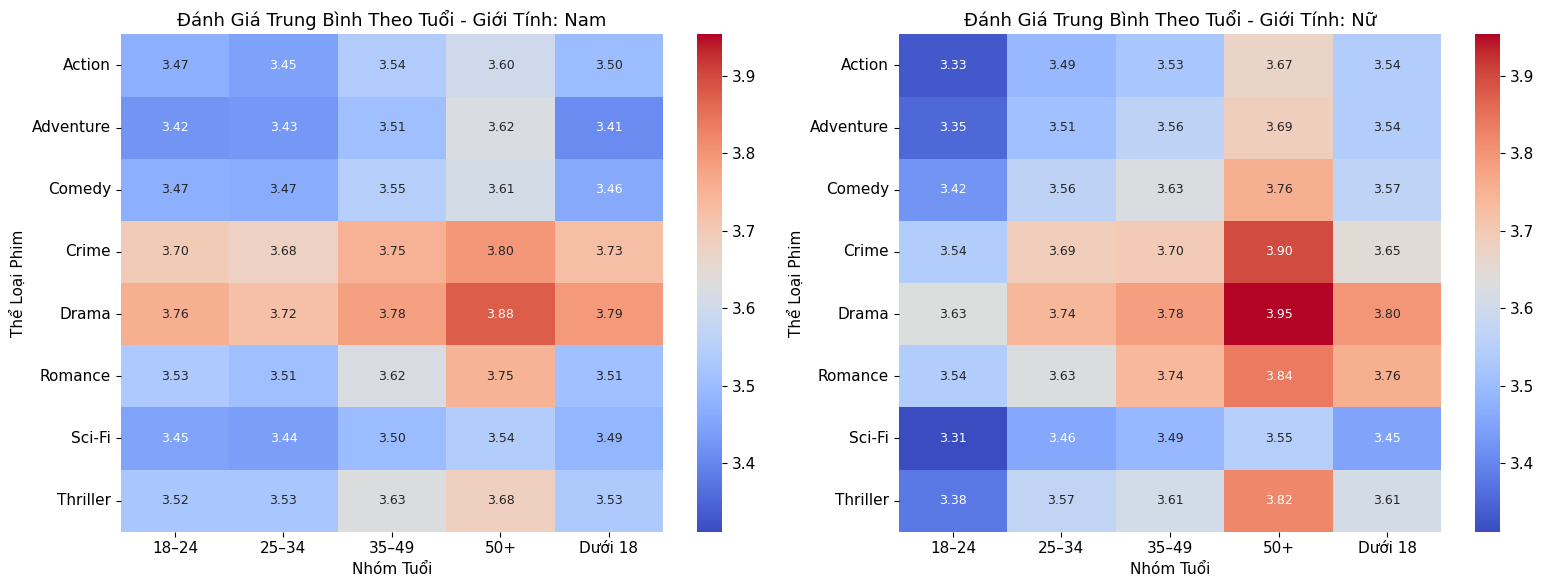

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🔹 Gộp dữ liệu
merged_data = ratings.merge(users, on="user_id").merge(movies, on="movie_id")

# 🔹 Chuẩn hóa cột thể loại
merged_data["genre"] = merged_data["genres"].str.split("|")
merged_exploded = merged_data.explode("genre").dropna(subset=["genre"])

# 🔹 Nhóm tuổi
def age_group(age):
    if age < 18:
        return "Dưới 18"
    elif age < 25:
        return "18–24"
    elif age < 35:
        return "25–34"
    elif age < 50:
        return "35–49"
    else:
        return "50+"

merged_exploded["AgeGroup"] = merged_exploded["age"].apply(age_group)

# 🔹 Tính điểm trung bình cho từng thể loại - nhóm tuổi - giới tính
pivot = merged_exploded.groupby(["genre", "AgeGroup", "gender"])["rating"].mean().reset_index()

# 🔹 Lấy 8 thể loại phổ biến nhất
top_genres = merged_exploded["genre"].value_counts().nlargest(8).index
pivot_top = pivot[pivot["genre"].isin(top_genres)]

# 🔹 Tạo pivot table cho 2 giới
pivot_male = pivot_top[pivot_top["gender"] == "M"].pivot(index="genre", columns="AgeGroup", values="rating")
pivot_female = pivot_top[pivot_top["gender"] == "F"].pivot(index="genre", columns="AgeGroup", values="rating")

# 🔹 Tạo biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Xác định giá trị min/max để đồng bộ thang màu
vmin = min(pivot_male.min().min(), pivot_female.min().min())
vmax = max(pivot_male.max().max(), pivot_female.max().max())

# 🔹 Heatmap cho Nam
sns.heatmap(pivot_male, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0],
            vmin=vmin, vmax=vmax, annot_kws={'size': 9})
axes[0].set_title("Đánh Giá Trung Bình Theo Tuổi - Giới Tính: Nam", fontsize=13)
axes[0].set_xlabel("Nhóm Tuổi", fontsize=11)
axes[0].set_ylabel("Thể Loại Phim", fontsize=11)

# 🔹 Heatmap cho Nữ
sns.heatmap(pivot_female, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1],
            vmin=vmin, vmax=vmax, annot_kws={'size': 9})
axes[1].set_title("Đánh Giá Trung Bình Theo Tuổi - Giới Tính: Nữ", fontsize=13)
axes[1].set_xlabel("Nhóm Tuổi", fontsize=11)
axes[1].set_ylabel("Thể Loại Phim", fontsize=11)

# 🔹 Hiển thị lại nhãn thể loại bên phải (để không bị ẩn)
axes[1].set_yticks(np.arange(len(pivot_female.index)) + 0.5)
axes[1].set_yticklabels(pivot_female.index, rotation=0)

plt.tight_layout()
plt.show()


Biểu đồ heatmap thể hiện rõ sự khác biệt trong thị hiếu giữa giới tính và độ tuổi:

- Ở nhóm nam giới trẻ (18–24 tuổi), các thể loại như Action, Sci-Fi, Adventure được đánh giá cao nhất.

- Nam lớn tuổi (35–49, 50+) lại có xu hướng chuộng Drama và History hơn.

- Nữ giới trẻ (18–24 tuổi) yêu thích Romance, Comedy, và Musical, trong khi nữ lớn tuổi lại nghiêng về Drama và Documentary.

- Nhìn chung, thể loại Comedy duy trì mức yêu thích ổn định ở mọi nhóm — cho thấy tính “trung tính” trong thị hiếu.

###4.6 Phân Tích Theo Tuổi Tác và Nghề Nghiệp
Sử dụng các cột *age* và *occupation* để hiểu rõ hơn về sở thích của các nhóm nhân khẩu học.

####Phân tích Rating Trung bình theo Nhóm Tuổi

- **Mục tiêu:** So sánh điểm đánh giá trung bình giữa các nhóm tuổi khác nhau, đặc biệt là nhóm trẻ nhất (1) và nhóm lớn tuổi nhất (56), cho thấy sự khác biệt về sở thích thế hệ.

- **Kỹ thuật:** Sử dụng *pivot_table* trên cột *age* và trực quan hóa so sánh điểm cho các phim được yêu thích nhất ở các nhóm tuổi cực đoan.


TOP 5 PHIM NHÓM 56+ THÍCH NHẤT:
 title
Better Off Dead... (1985)                          5.000000
Creature Comforts (1990)                           5.000000
Wrong Trousers, The (1993)                         4.722222
Seventh Seal, The (Sjunde inseglet, Det) (1957)    4.666667
Inherit the Wind (1960)                            4.625000
Name: 56, dtype: float64

TOP 5 PHIM NHÓM 18-24 THÍCH NHẤT:
 title
Usual Suspects, The (1995)                                             4.680798
Shawshank Redemption, The (1994)                                       4.674569
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)    4.604938
Close Shave, A (1995)                                                  4.568000
Life Is Beautiful (La Vita è bella) (1997)                             4.549180
Name: 18, dtype: float64


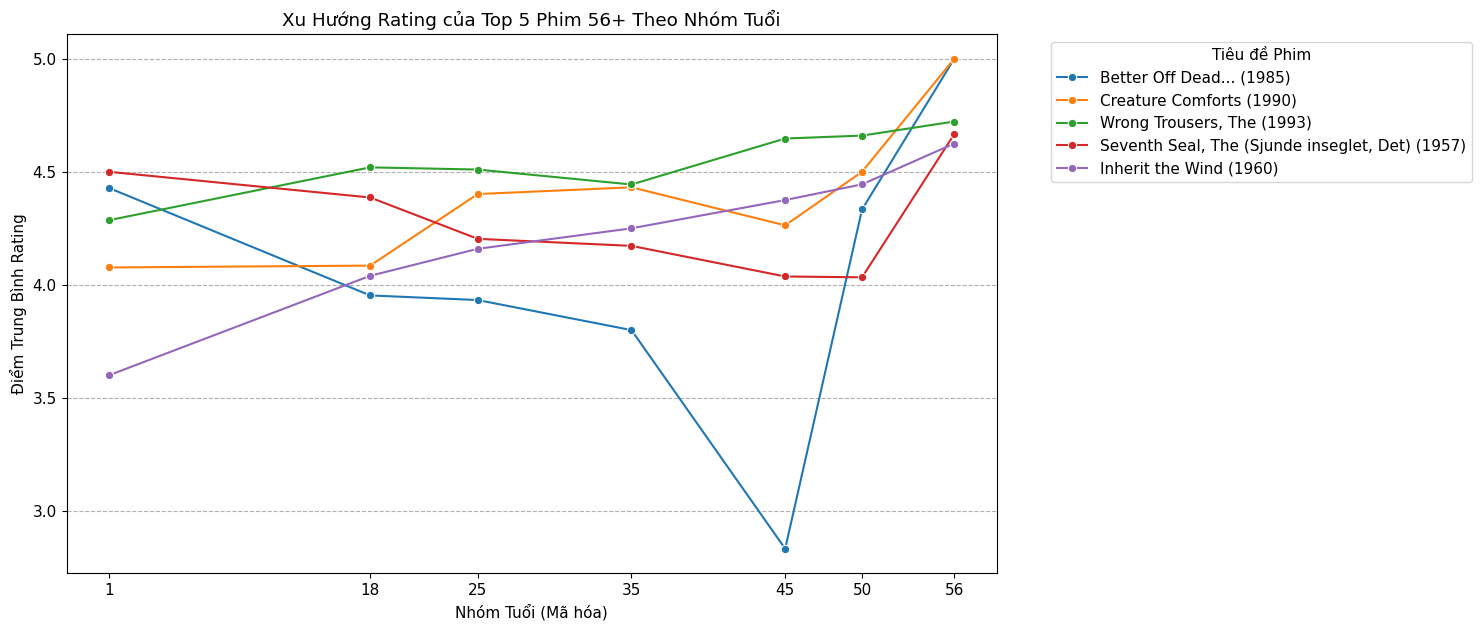

In [ ]:
# Tính rating trung bình theo title và age (chỉ dùng active_titles đã lọc)
# Age columns: 1 (Under 18), 18 (18-24), 25 (25-34), 35 (35-44), 45 (45-49), 50 (50-55), 56 (56+)
age_mean_ratings = data.pivot_table("rating", index="title", columns="age", aggfunc="mean")
age_mean_ratings = age_mean_ratings.loc[active_titles]

# Chọn Top 5 phim được nhóm 56+ và Top 5 phim được nhóm 18-24 (Age=18) thích nhất
top_5_age_56 = age_mean_ratings.sort_values(56, ascending=False).head(5)
top_5_age_18 = age_mean_ratings.sort_values(18, ascending=False).head(5)

print("\nTOP 5 PHIM NHÓM 56+ THÍCH NHẤT:\n", top_5_age_56[56])
print("\nTOP 5 PHIM NHÓM 18-24 THÍCH NHẤT:\n", top_5_age_18[18])

# Trực quan hóa so sánh điểm rating trung bình của Top 5 phim 56+ trên các nhóm tuổi
plot_data_age = top_5_age_56.reset_index().melt(
    id_vars='title',
    value_vars=age_mean_ratings.columns,
    var_name='Age Group',
    value_name='Mean Rating'
)

plt.figure(figsize=(12, 7))
sns.lineplot(data=plot_data_age, x='Age Group', y='Mean Rating', hue='title', marker='o')
plt.title("Xu Hướng Rating của Top 5 Phim 56+ Theo Nhóm Tuổi")
plt.xlabel("Nhóm Tuổi (Mã hóa)")
plt.ylabel("Điểm Trung Bình Rating")
plt.xticks(age_mean_ratings.columns)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Tiêu đề Phim', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Nhận xét và Phân tích ngắn gọn:**
- **Xu hướng thế hệ:** Biểu đồ đường cho thấy xu hướng điểm đánh giá của các phim được nhóm tuổi 56+ ưa thích nhất trên các nhóm tuổi khác.

- **Sự đồng thuận:** Nếu đường đi ngang hoặc đi lên ở nhóm tuổi lớn hơn, điều đó củng cố sự ưa chuộng của thế hệ này. Ngược lại, việc điểm giảm dần ở các nhóm tuổi trẻ hơn (1, 18) cho thấy sự khác biệt về sở thích thế hệ.

- **Tính ổn định:** Phim được 56+ yêu thích thường có xu hướng giữ điểm ổn định hoặc đạt đỉnh ở nhóm lớn tuổi, xác nhận tính "kinh điển" hoặc sự phù hợp với thế hệ đó.

#### Phân tích Rating Trung bình theo Nghề nghiệp

- **Mục tiêu:** Xác định các nghề nghiệp có xu hướng đánh giá cao thể loại phim cụ thể (ví dụ: Drama) nhất.

- **Kỹ thuật:** Lọc phim theo thể loại, tính rating trung bình theo *occupation* và dùng biểu đồ thanh để làm nổi bật top nghề nghiệp.


RATING TB PHIM DRAMA THEO MÃ NGHỀ NGHIỆP (Top 10):
               rating
occupation          
13          3.949047
6           3.871756
12          3.840207
15          3.836070
17          3.800158
16          3.791983
9           3.791185
3           3.790601
14          3.788018
10          3.782167


/tmp/ipython-input-607330453.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_occ_drama['rating'].values, y=top_10_occ_drama.index, palette='viridis')


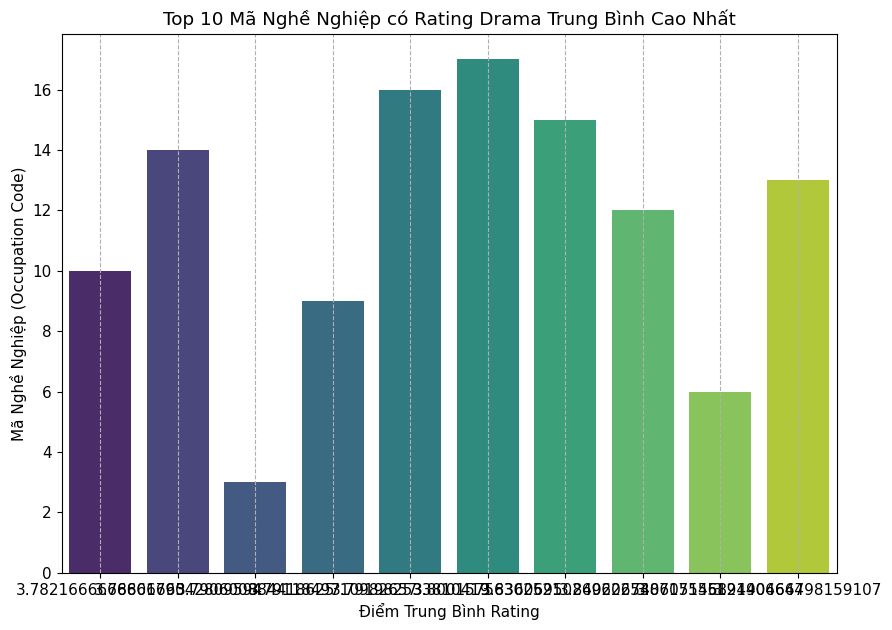

In [ ]:
# 1. Lọc các rating cho phim có chứa thể loại 'Drama'
drama_movies = data[data['genres'].str.contains('Drama', na=False)]

# 2. Tính rating trung bình của phim Drama theo Occupation
drama_ratings_by_occ = drama_movies.pivot_table(
    'rating',
    index='occupation',
    aggfunc='mean'
).sort_values('rating', ascending=False)

# Chọn Top 10 nghề nghiệp thích Drama nhất
top_10_occ_drama = drama_ratings_by_occ.head(10)

print("\nRATING TB PHIM DRAMA THEO MÃ NGHỀ NGHIỆP (Top 10):\n", top_10_occ_drama)

# Trực quan hóa
plt.figure(figsize=(10, 7))
# Sửa lỗi: Truy cập cột 'rating' (hoặc tên cột tương ứng) trước khi dùng .values
sns.barplot(x=top_10_occ_drama['rating'].values, y=top_10_occ_drama.index, palette='viridis')
plt.title("Top 10 Mã Nghề Nghiệp có Rating Drama Trung Bình Cao Nhất")
plt.xlabel("Điểm Trung Bình Rating")
plt.ylabel("Mã Nghề Nghiệp (Occupation Code)")
plt.grid(axis='x', linestyle='--')
plt.show()

**Nhận xét và Phân tích ngắn gọn:**
- **Độ chuyên biệt:** Phân tích này tiết lộ sự khác biệt về sở thích chi tiết hơn so với phân tích theo giới tính/tuổi. Ví dụ: Mã nghề nghiệp nào có điểm trung bình Drama cao nhất (trên 3.8) thể hiện sự ưu ái rõ rệt.

- **Ứng dụng:** Kết quả này rất hữu ích cho hệ thống gợi ý, vì nó cho phép tạo hồ sơ sở thích dựa trên nghề nghiệp, đề xuất phim phù hợp với đặc điểm nhân khẩu học này.

- **Hạn chế:** Để có phân tích sâu hơn, cần tra cứu bảng mã hóa chi tiết để biết ý nghĩa thực sự của các mã nghề nghiệp này (Occupation Code).

/tmp/ipython-input-3994162260.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


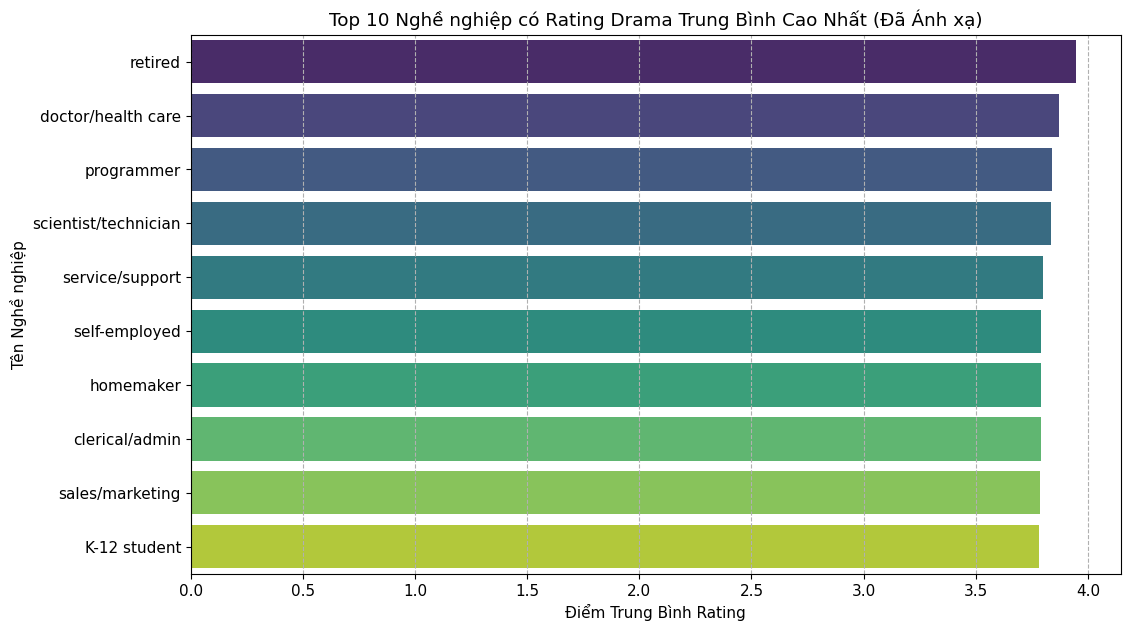

In [ ]:
# 1. Định nghĩa Ánh xạ Mã nghề nghiệp (dựa trên README MovieLens 1M)
occupation_map = {
    0: "not specified", 1: "academic/educator", 2: "artist",
    3: "clerical/admin", 4: "college/grad student", 5: "customer service",
    6: "doctor/health care", 7: "executive/managerial", 8: "farmer",
    9: "homemaker", 10: "K-12 student", 11: "lawyer",
    12: "programmer", 13: "retired", 14: "sales/marketing",
    15: "scientist/technician", 16: "self-employed", 17: "service/support",
    18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
}

# top_10_occ_drama là một Series/DataFrame có index là mã số nghề nghiệp
# 2. Ánh xạ (Map) index (mã số) sang tên nghề nghiệp
top_10_occ_drama_mapped = top_10_occ_drama.reset_index()
top_10_occ_drama_mapped['occupation_name'] = top_10_occ_drama_mapped['occupation'].map(occupation_map)

# 3. Trực quan hóa với tên nghề nghiệp
plt.figure(figsize=(12, 7))
# Sửa lỗi cũ: Đảm bảo truyền DataFrame và chỉ định tên cột
sns.barplot(
    x='rating',
    y='occupation_name',
    data=top_10_occ_drama_mapped,
    palette='viridis' # Giữ màu sắc đẹp mắt
)

plt.title("Top 10 Nghề nghiệp có Rating Drama Trung Bình Cao Nhất (Đã Ánh xạ)")
plt.xlabel("Điểm Trung Bình Rating")
plt.ylabel("Tên Nghề nghiệp")
plt.grid(axis='x', linestyle='--')
plt.show()

#### Tổng Hợp Phân Tích Theo Tuổi Tác và Nghề Nghiệp

Đầu tiên, chúng ta cần ánh xạ mã nghề nghiệp sang tên thực tế trong DataFrame *ratings_with_genre* (đã explode thể loại) và tính toán *pivot table*.

In [ ]:
# Cần đảm bảo DataFrame 'ratings_with_genre' đã được tạo từ bước 4.4 trước đó
# và các thư viện cần thiết đã được import (pandas, numpy, matplotlib.pyplot, seaborn)

# 1. Định nghĩa Ánh xạ Mã nghề nghiệp (dựa trên README MovieLens 1M)
occupation_map = {
    0: "Not Specified", 1: "Academic/Educator", 2: "Artist",
    3: "Clerical/Admin", 4: "College/Grad Student", 5: "Customer Service",
    6: "Doctor/Health Care", 7: "Executive/Managerial", 8: "Farmer",
    9: "Homemaker", 10: "K-12 Student", 11: "Lawyer",
    12: "Programmer", 13: "Retired", 14: "Sales/Marketing",
    15: "Scientist/Technician", 16: "Self-Employed", 17: "Service/Support",
    18: "Tradesman/Craftsman", 19: "Unemployed", 20: "Writer"
}

# 2. Ánh xạ Mã nghề nghiệp sang Tên (Thêm cột mới)
ratings_with_genre['occupation_name'] = ratings_with_genre['occupation'].map(occupation_map)

# 3. Tính Rating Trung bình cho TẤT CẢ các thể loại theo TÊN nghề nghiệp
full_genre_occ_ratings = ratings_with_genre.pivot_table(
    'rating',
    index='occupation_name',
    columns='genre',
    aggfunc='mean'
)

print("\nPivot Table Rating TB (Nghề nghiệp x Thể loại) - 5 dòng đầu:\n", full_genre_occ_ratings.head())


Pivot Table Rating TB (Nghề nghiệp x Thể loại) - 5 dòng đầu:
 genre                   Action  Adventure  Animation  Children's    Comedy  \
occupation_name                                                              
Academic/Educator     3.392063   3.424278   3.693399    3.459286  3.519583   
Artist                3.457569   3.443535   3.624133    3.377481  3.504449   
Clerical/Admin        3.549025   3.556486   3.822104    3.609614  3.601516   
College/Grad Student  3.453687   3.419877   3.655628    3.346680  3.486563   
Customer Service      3.494995   3.478934   3.766940    3.513463  3.474962   

genre                    Crime  Documentary     Drama   Fantasy  Film-Noir  \
occupation_name                                                              
Academic/Educator     3.659342     3.984887  3.754293  3.456388   4.082613   
Artist                3.678039     4.028933  3.732216  3.424432   4.114000   
Clerical/Admin        3.742811     3.852632  3.790601  3.472675   4.075332   


Code: Trực quan hóa bằng Heatmap

Sử dụng Heatmap để trực quan hóa toàn bộ ma trận 21x21 này. Heatmap là phương pháp tốt nhất để nhận dạng các mẫu hình (pattern) và điểm nổi bật (outlier) trong dữ liệu đa chiều.

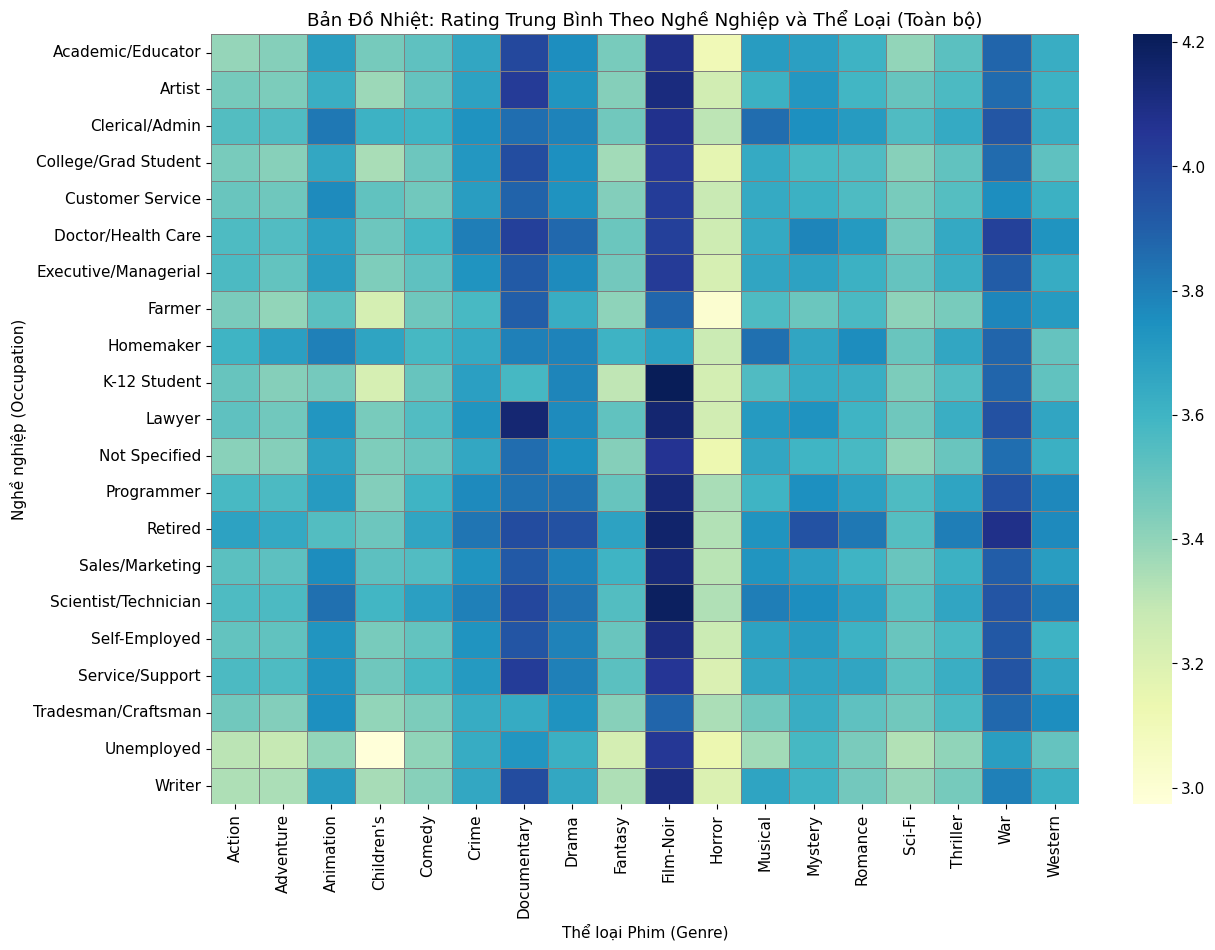

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    full_genre_occ_ratings,
    annot=False, # Tắt hiển thị số để tránh quá tải
    fmt=".2f",
    cmap="YlGnBu", # Chọn màu sắc dễ nhìn và thể hiện cường độ
    linewidths=.5,
    linecolor='gray'
)

plt.title("Bản Đồ Nhiệt: Rating Trung Bình Theo Nghề Nghiệp và Thể Loại (Toàn bộ)")
plt.xlabel("Thể loại Phim (Genre)")
plt.ylabel("Nghề nghiệp (Occupation)")
plt.show()

**Nhận xét và Phân tích ngắn gọn (Toàn cảnh):**
- **Màu sắc và Xu hướng:** Màu xanh đậm trên Heatmap biểu thị các thể loại được nhóm nghề nghiệp đó đánh giá rất cao (≈4.0 sao trở lên). Màu vàng nhạt biểu thị các rating trung bình thấp hơn .

- **Thể loại được Ưu ái Chung:** Các cột có màu xanh đậm xuyên suốt nhiều nghề nghiệp (ví dụ: Film-Noir, Documentary) cho thấy đây là những thể loại được đồng thuận và đánh giá cao nhất bất kể nghề nghiệp.

**Sở thích Chuyên biệt:**

- **Programmers/Scientists:** Thường có xu hướng đánh giá cao các thể loại Sci-Fi và Mystery, có thể liên quan đến tính logic và trí tuệ.

- **K-12 Student/College/Grad Student:** Thường có xu hướng đánh giá cao các thể loại Children's và các phim giải trí nhẹ nhàng, nhưng có thể đánh giá thấp hơn các thể loại kinh điển như War hay Film-Noir so với nhóm tuổi lớn hơn.

- *Retired/Homemaker:* Thường là nhóm đánh giá cao các thể loại Drama và Romance.

**Hiệu quả Heatmap:** Mặc dù không hiển thị số, Heatmap cho phép bạn quét nhanh toàn bộ ma trận, dễ dàng nhận ra các "điểm nóng" (ô xanh đậm) và "điểm lạnh" (ô vàng nhạt) của sự khác biệt về sở thích.

##5. Kết luận và Ý nghĩa Phân tích
Phân tích sâu bộ dữ liệu MovieLens 1M đã khám phá các xu hướng sở thích rõ rệt dựa trên giới tính, độ tuổi và nghề nghiệp, vượt xa các chỉ số rating trung bình đơn thuần.

###5.1. Tổng hợp các Phát hiện Chính


- **Sự Phân cực Giới tính (Top F, Top M, Top Difference):**

  - Sở thích phim phân cực rõ rệt: Nam giới có xu hướng đánh giá cao hơn các thể loại Viễn Tây, Chiến tranh, và Hài (thô tục). Ngược lại, Nữ giới ưa chuộng các thể loại Nhạc kịch, Lãng mạn (Romance), và phim hoạt hình ngắn.

  - Các phim gây chia rẽ ý kiến mạnh nhất (độ lệch chuẩn σ cao, ví dụ: Dumb & Dumber 1.32) thường là phim hài cực đoan hoặc kinh dị gây tranh cãi.

- **Xu hướng Nhân khẩu học (Age & Occupation):**

  - Ảnh hưởng của Tuổi: Các nhóm tuổi lớn hơn (50, 56+) có xu hướng đánh giá cao hơn nhiều thể loại, đặc biệt là Drama và Phim cổ điển, so với các nhóm sinh viên trẻ tuổi (1, 18).

  - Ảnh hưởng của Nghề nghiệp (Heatmap): Heatmap cho thấy các nghề nghiệp trí tuệ (Programmer, Scientist/Technician) có sự ưu tiên rõ rệt đối với các thể loại Sci-Fi và Mystery, trong khi các thể loại có tính nghệ thuật cao như Film-Noir và Documentary được đánh giá cao và đồng đều ở hầu hết mọi nhóm nghề nghiệp.

- **Hoạt động theo Thời gian (Temporal):**

  - Người dùng có xu hướng tập trung đánh giá phim vào các giờ cao điểm buổi tối (sau 8 giờ tối), phản ánh hành vi giải trí sau giờ làm việc.

###5.2. Ý nghĩa đối với Phân tích Dữ liệu

- **Nhu cầu làm sạch dữ liệu:** Việc lọc các phim có rating thấp (≥250 ratings) là bước cơ bản và quan trọng để đảm bảo tất cả các phân tích thống kê tiếp theo (như tính độ lệch chuẩn và điểm trung bình) đều dựa trên một tập hợp dữ liệu đáng tin cậy.

- **Kỹ thuật xử lý dữ liệu phức tạp:** Các kỹ thuật như pd.merge để gộp ba bảng, str.split và explode để xử lý cột đa giá trị (genres), cùng pivot_table và heatmap để trực quan hóa ma trận sở thích, là những công cụ tối ưu để trích xuất ý nghĩa từ các tập dữ liệu phức tạp.